# Practical 1: Magicgui Widget

## Load sample data

We will first load the sample image `cells3d` from `scikit-image`. The image is a 3D volume with two channels. As a start, we will only consider a 2D slice from the nuclei channel. 

We will then open the image in napari with `napari.view_image`. 

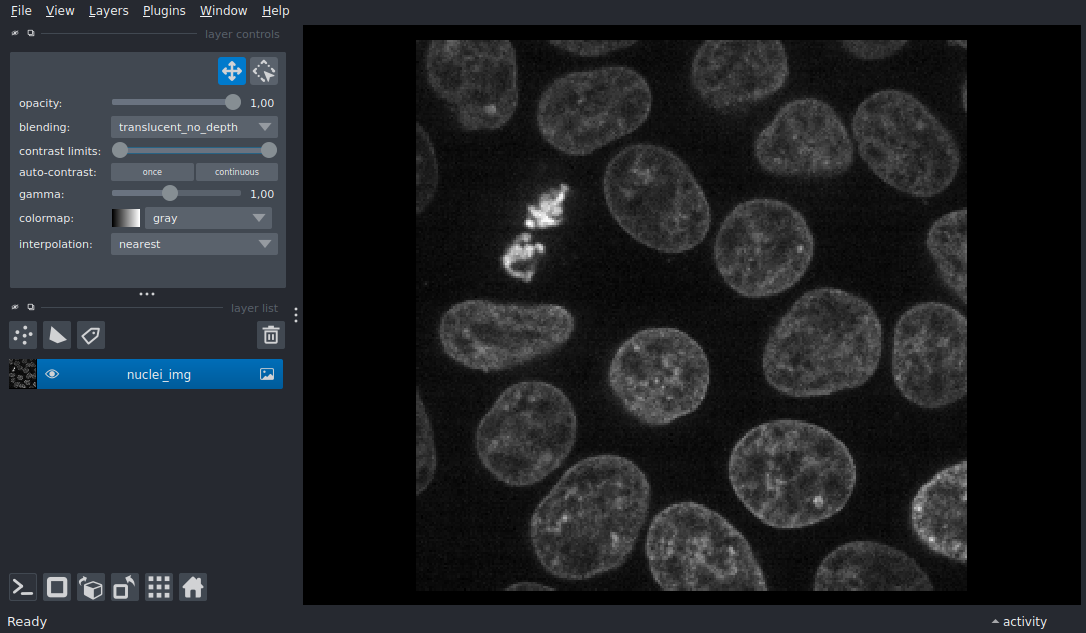

In [5]:
from skimage import data
import napari

nuclei_img = data.cells3d()[30,1]

viewer = napari.view_image(nuclei_img)
napari.utils.nbscreenshot(viewer)

## Simple thresholding function

### Thresholding
Thresholding is an easy image segmentation technique that separates an image into "foreground" and "background" pixels based on a pixel value threshold. The result of the thresholding is then stored in a binary image where "foreground" pixels are denoted by "1" or `True` and "background" pixels by "0" or `False`.

- For more information: [Wikipedia](https://en.wikipedia.org/wiki/Thresholding_(image_processing)), [scikit-image](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html)

### Define thresholding function
The simplest algorithm is to apply the same threshold to each pixel in the input image. We will now define the function `threshold_image` which takes `input_img` and `threshold` as arguments. 

To convert our input image from 16-bit to floating points (i.e. defined between 0 and 1), we will use the `img_as_float` function from `scikit-image`.

Our function will return a binary image. 

In [8]:
import numpy as np 
from skimage.util import img_as_float

def threshold_image(input_img: np.ndarray, threshold: float) -> np.ndarray:
    # Convert to float
    img = img_as_float(input_img)
    # Apply threshold
    thresh_img = img > threshold
    
    return thresh_img

### Verify function

We will use our sample image `nuclei_img` to verify the functionality of the plugin. To show the result, we will use the `imshow` function from `matplotlib`. 

- [Documentation for `matplotlib.pyplot.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

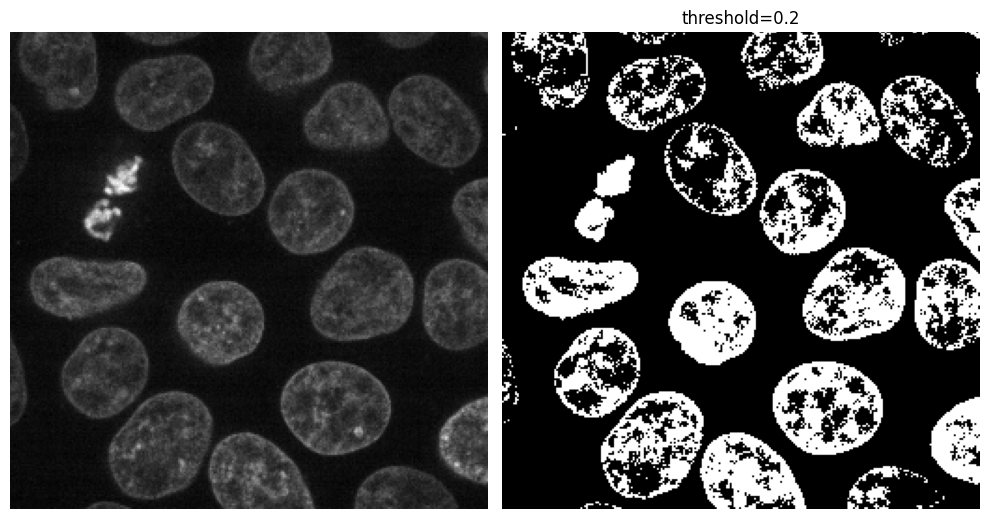

In [32]:
# Define a threshold value
threshold = 0.2

# Obtain results from thresholding function
thresh_img = threshold_image(nuclei_img, threshold)

# Show image and thresholding result side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10,20))
ax[0].imshow(nuclei_img, cmap='gray')
ax[0].axis('off')
ax[1].imshow(thresh_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'threshold={threshold}')
fig.tight_layout()
plt.show()

## Opening images and labels in napari

We can also use napari to inspect the results ouf our thresholding. To open `thresh_img` in napari, we will use `viewer.add_labels`. 

- For more information: [Image layer](https://napari.org/stable/howtos/layers/image.html), [Labels layer](https://napari.org/stable/howtos/layers/labels.html)

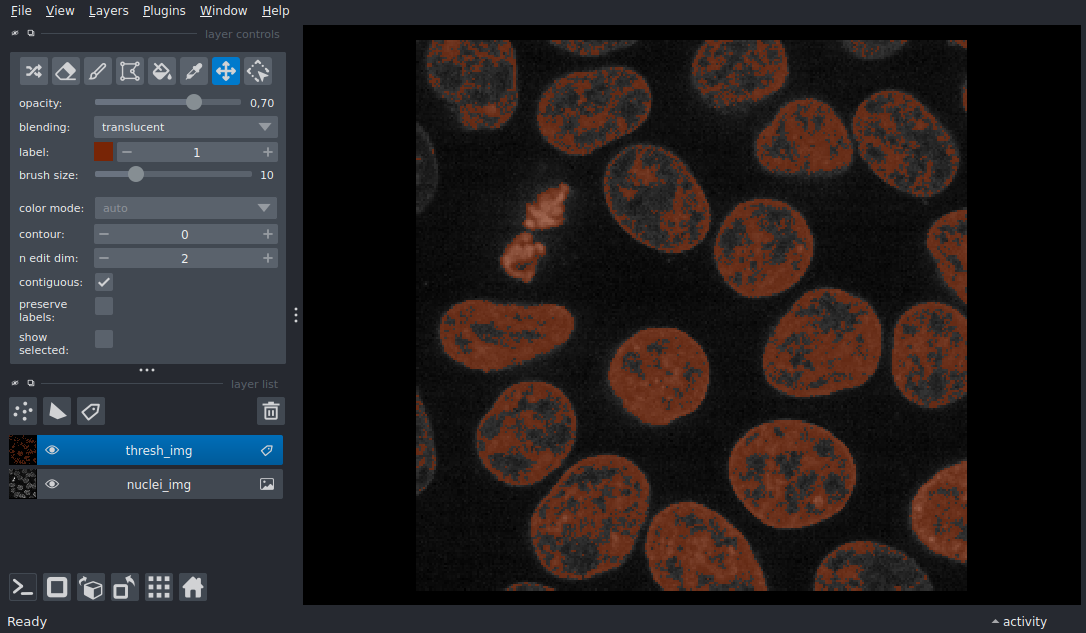

In [34]:
viewer = napari.view_image(nuclei_img)
viewer.add_labels(thresh_img)
napari.utils.nbscreenshot(viewer)

## Making our function compatible with napari layers

Now, we will modify our `threshold_image` function to interact with [napari layers](https://napari.org/stable/api/napari.layers.html). Currently, our images are stored in `numpy` arrays. We will first convert our sample data `nuclei_img` to a napari Image layer and provide appropriate parameters like `name` or `colormap`. 

Then, we will open our napari `Image` as a layer with `viewer.add_layer`

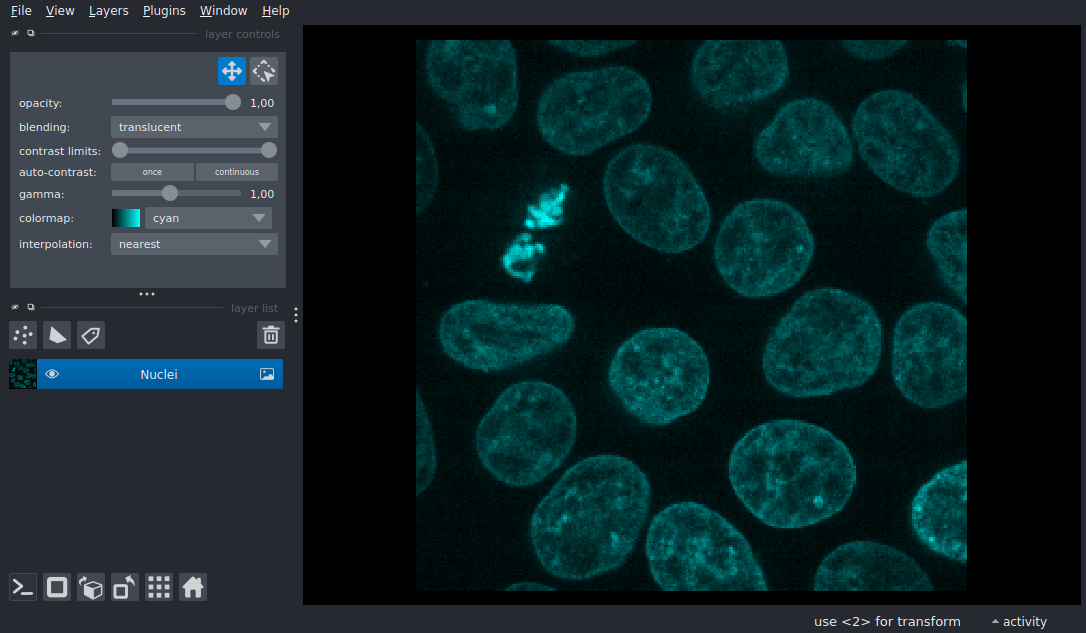

In [41]:
from napari.layers import Image

nuclei_img_layer = Image(nuclei_img, name='Nuclei', colormap='cyan')

viewer = napari.Viewer()
viewer.add_layer(nuclei_img_layer)
napari.utils.nbscreenshot(viewer)

We will now convert our `thresh_img` to a `Labels` layer and open it in napari

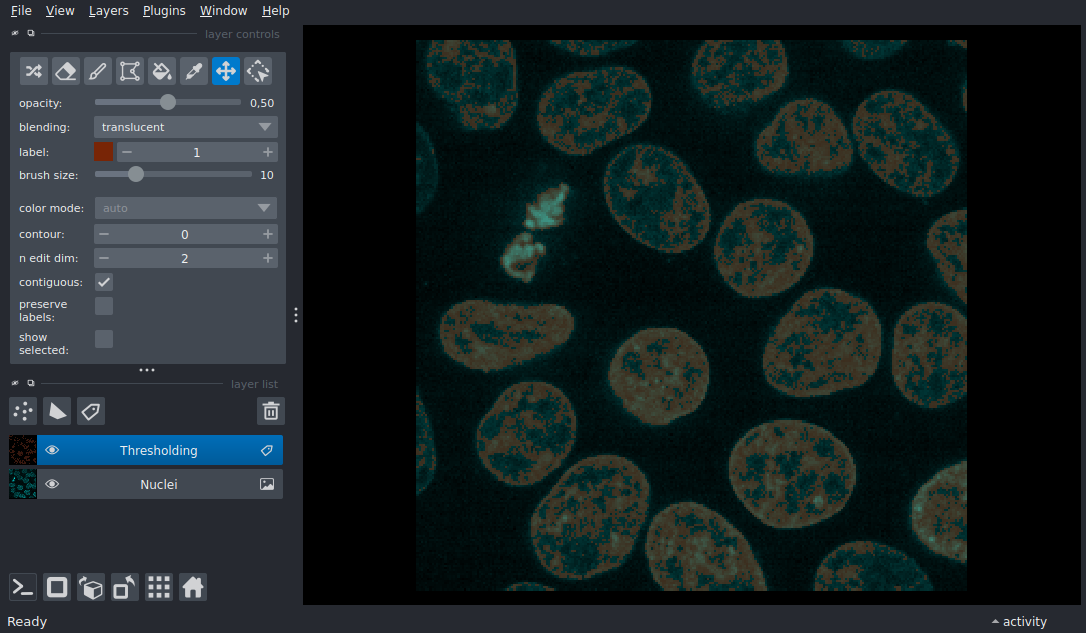

In [42]:
from napari.layers import Labels

thresh_img_layer = Labels(thresh_img, name='Thresholding', opacity=0.5)

viewer = napari.Viewer()
viewer.add_layer(nuclei_img_layer)
viewer.add_layer(thresh_img_layer)
napari.utils.nbscreenshot(viewer)

### Modify thresholding function

We will now modify the function [type hints](https://docs.python.org/3.11/library/typing.html) according to the type of napari layer we expect. Recall that our function accepts an image and returns a binary labeled image. Therefore, our `input_img` variable should accept `napari.layers.Image` and our function should return `napari.layers.Labels`.

Napari layers are objects (i.e. defined by the [`napari.layers.Layer` class](https://napari.org/stable/api/napari.layers.Layer.html#napari.layers.Layer) and we therefore need to access the underlying image data using the attribute `data` in our function.

Verify that the function works as expected and open the `Image` and `Labels` layers in napari.

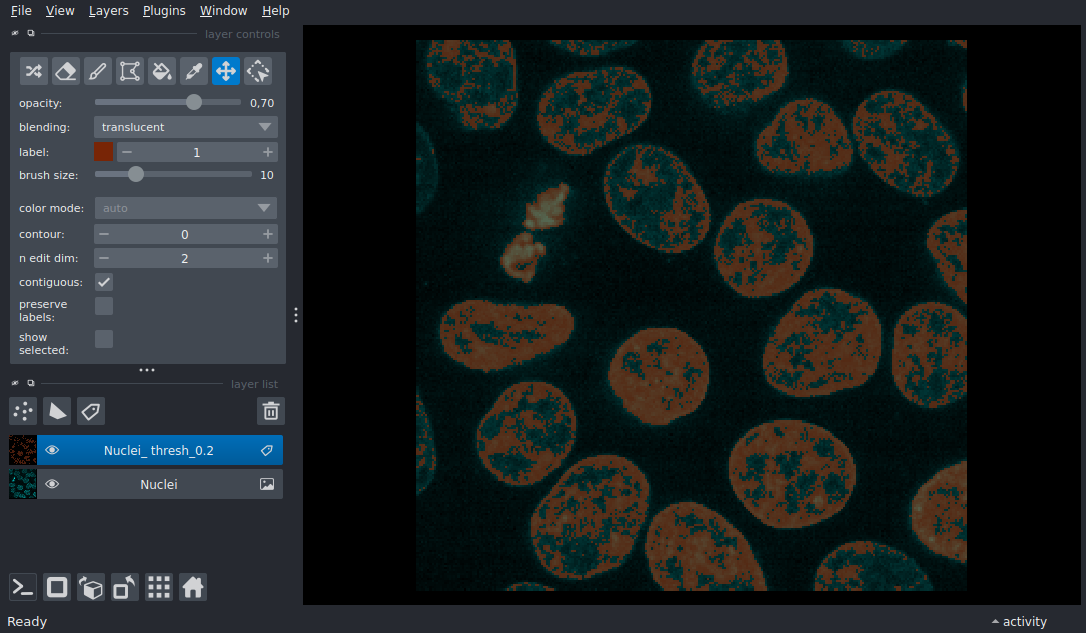

In [56]:
def threshold_image(input_img: Image, threshold: float) -> Labels:
    # Convert to float
    img = img_as_float(input_img.data)
    # Apply threshold
    thresh_img = img > threshold
    
    return Labels(thresh_img, name=f'{input_img.name}_ thresh_{threshold}')

threshold=0.2
thresh_img_layer = threshold_image(nuclei_img_layer, threshold)

viewer = napari.Viewer()
viewer.add_layer(nuclei_img_layer)
viewer.add_layer(thresh_img_layer)
napari.utils.nbscreenshot(viewer)

## Making a widget from our function

We will now convert our previously defined function to a `magicgui` widget which we can add to our napari viewer. The `magicgui` library is a high-level package based on a GUI toolkit backend (e.g. QtPy) to build small widgets using function type hints. To convert our function to a widget, we only have to add the `@magicgui` decorator and dock our widget to napari with `viewer.window.add_dock_widget`.

- For more information: [Documentation for `magicgui`](https://pyapp-kit.github.io/magicgui/), [Type Hint to Widget Mapping in `magicgui`](https://pyapp-kit.github.io/magicgui/type_map/)

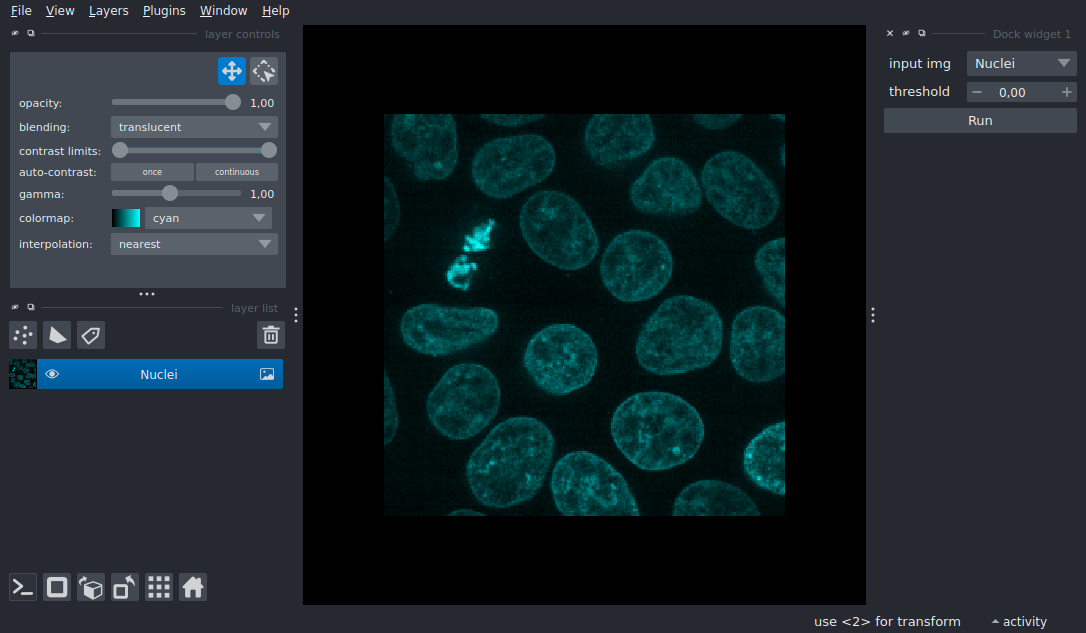

In [61]:
from magicgui import magicgui
from napari.types import LabelsData

@magicgui
def threshold_image(input_img: Image, threshold: float) -> LabelsData:
    # Convert to float
    img = img_as_float(input_img.data)
    # Apply threshold
    thresh_img = img > threshold
    
    return thresh_img

viewer = napari.Viewer()
viewer.add_layer(nuclei_img_layer)
viewer.window.add_dock_widget(threshold_image)
napari.utils.nbscreenshot(viewer)

## Adapting magicgui widget

We will now modify the behavioiur of our widget by passing corresponding `kwargs` for some of our function parameters in the `magicgui` decorator. We will pass additional `kwargs` as a `dict`.

We will first change the label on the `call_button` to "Run thresholding". Then, we will change the default [`FloatSpinBox`](https://pyapp-kit.github.io/magicgui/api/widgets/FloatSpinBox/) to a [`FloatSlider`](https://pyapp-kit.github.io/magicgui/api/widgets/FloatSlider/) widget by specifying `widget_type`. We will also define a minimum (`min`), a maximum (`max`) and a default (`value`) value. We can also change the label of each parameter by specifying `label`.

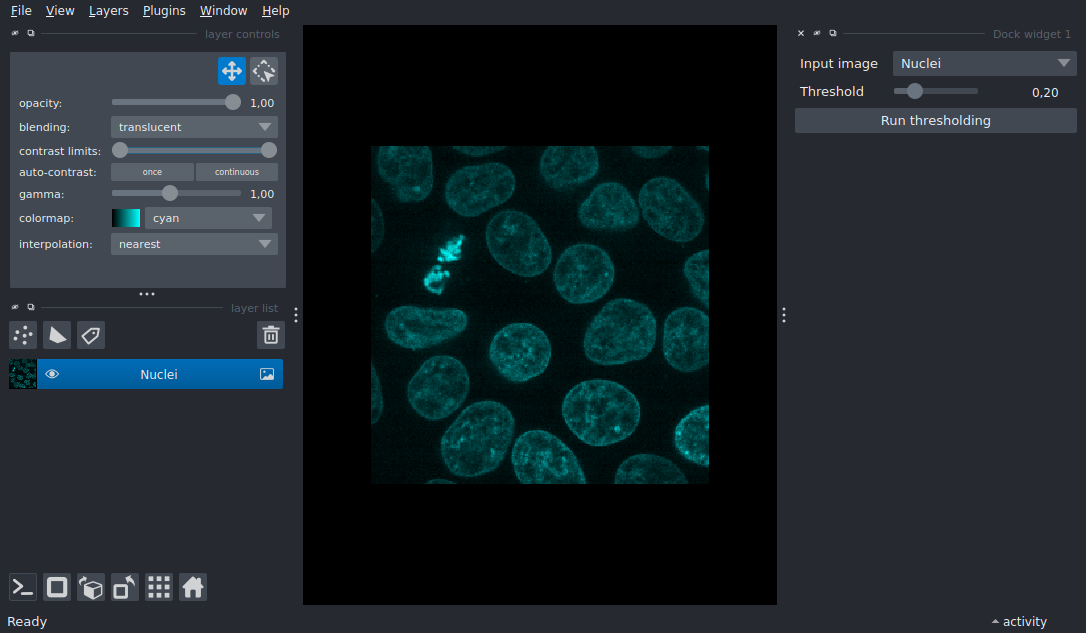

In [67]:
@magicgui(
    call_button='Run thresholding',
    input_img={'label': 'Input image'},
    threshold={'label': 'Threshold',
               'widget_type': 'FloatSlider',
               'min': 0,
               'max': 1,
               'value': 0.2}
)
def threshold_image(input_img: Image, threshold: float) -> LabelsData:
    # Convert to float
    img = img_as_float(input_img.data)
    # Apply threshold
    thresh_img = img > threshold
    
    return thresh_img

viewer = napari.Viewer()
viewer.add_layer(nuclei_img_layer)
viewer.window.add_dock_widget(threshold_image)
napari.utils.nbscreenshot(viewer)

By setting `auto_call` to `True`, our function runs whenever the value for `threshold` is modified by the user

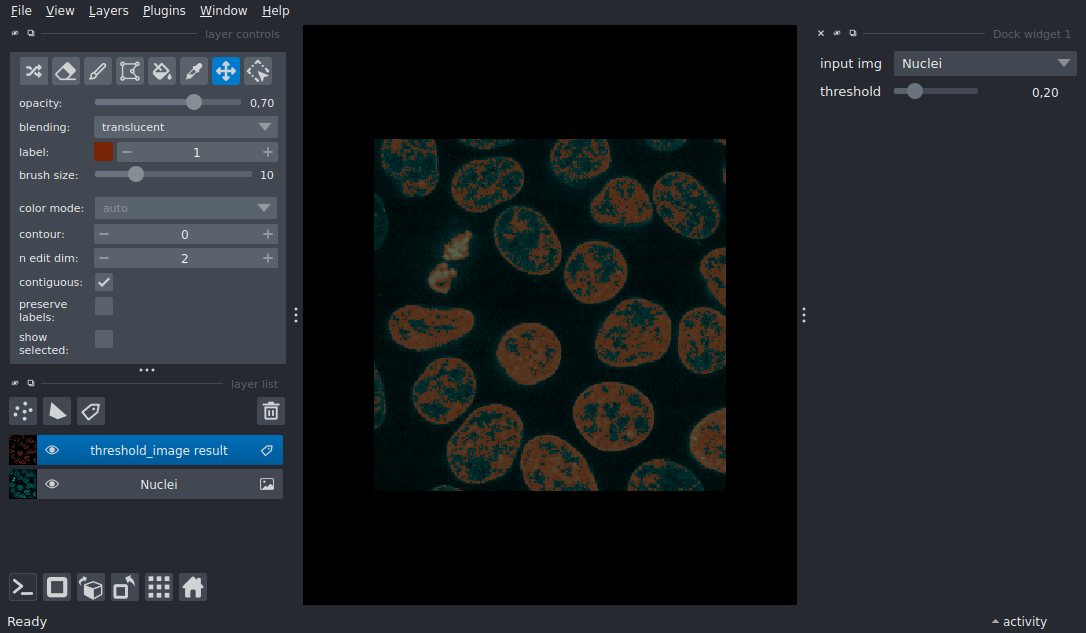

In [65]:
@magicgui(
    auto_call=True,
    threshold={'widget_type': 'FloatSlider',
               'min': 0,
               'max': 1,
               'value': 0.2}
)
def threshold_image(input_img: Image, threshold: float) -> LabelsData:
    # Convert to float
    img = img_as_float(input_img.data)
    # Apply threshold
    thresh_img = img > threshold
    
    return thresh_img

viewer = napari.Viewer()
viewer.add_layer(nuclei_img_layer)
viewer.window.add_dock_widget(threshold_image)
napari.utils.nbscreenshot(viewer)